# Optimization Problems on Quantum

Solving optimization problems on quantum computers typically involves mapping the optimization problem to a quantum form, preparing a quantum state that represents potential solutions, and using quantum algorithms to explore the solution space. Below is a step-by-step guide with mathematical descriptions for solving optimization problems on quantum computers, specifically using the Variational Quantum Algorithms (VQAs):



## 1. Formulate the Optimization Problem

Define the objective function and constraints of the optimization problem. For example, let's consider a simple binary quadratic optimization problem:

$$minimize \text{  } f(x_0, x_1) = \text{   } x_0+x_1-x_0x_1$$




In [29]:
from docplex.mp.model import Model

n=2 #number of variables, for our case it is x_0 and x_1
mdl = Model("Example_1")
x = mdl.binary_var_list('x{}'.format(i) for i in range(n)) #create binary variables

objective = mdl.sum([x[0]+x[1]-x[0]*x[1]])
mdl.minimize(objective)
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: Example_1
// var contrainer section
dvar bool x[2];

minimize
 x0 + x1 [ - x0*x1 ];
 
subject to {

}


In [30]:
#convert to quadratic program
from qiskit_optimization.translators import from_docplex_mp
qp = from_docplex_mp(mdl)
print(qp.prettyprint())

Problem name: Example_1

Minimize
  -x0*x1 + x0 + x1

Subject to
  No constraints

  Binary variables (2)
    x0 x1



## 2. Map to a Hamiltonian:

Express the objective function and constraints in terms of Pauli operators to form a Hamiltonian H_c. Here we willl convert into Pauli-Z operator, because eigenvalues of the Pauli-Z operator are binary (1 and -1), making it suitable for encoding binary variables in our optimization problems:

$$x_i=\frac{1-Z_i}{2}$$

Thus, by substituting $x$, we get 

$$H_c = \frac{1-Z_0}{2} + \frac{1-Z_1}{2} - \frac{1-Z_0}{2}\frac{1-Z_1}{2}
      =0.75 - 0.25Z_0-0.25Z_1-0.25Z_0Z_1$$

Constant terms (here is 0.75) in the objective function can often be dropped without affecting the optimization process. This is because the energy spectrum of the Hamiltonian is determined by the differences in eigenvalues rather than the absolute values. Or in other way, we can say that adding or subtracting a constant value to all eigenvalues of a Hamiltonian does not change the energy differences or the relative ordering of the eigenvalues.


In [31]:
from qiskit_optimization.converters import LinearEqualityToPenalty
#lineq2penalty = LinearEqualityToPenalty()
#qp = lineq2penalty.convert(qp)
H_c, offset = qp.to_ising()
print('H_c = ', H_c)

H_c =  -0.25 * IZ
- 0.25 * ZI
- 0.25 * ZZ


You got Hamiltonian H_c = -0.25*IZ-0.25ZI-0.25ZZ. And if you expand it , you will get a matrix form as follows:

In [71]:
H_matrix = np.real(H_c.to_matrix())
print('dimension of H: ', H_matrix.shape)
print(H_matrix)


dimension of H:  (4, 4)
[[-0.75  0.    0.    0.  ]
 [ 0.    0.25  0.    0.  ]
 [ 0.    0.    0.25  0.  ]
 [ 0.    0.    0.    0.25]]


Now, we have a diagonal matrix H_c, with eigenvalues -0.75, 0.25, 0.25 and 0.25. Each of the eigenvalues correspond to eigenstate 00, 01, 10, 11 respectively.  The lowest one is -0.75 (with eigenstate 00), which is also the solution we were looking. Let's visualize as follows, 

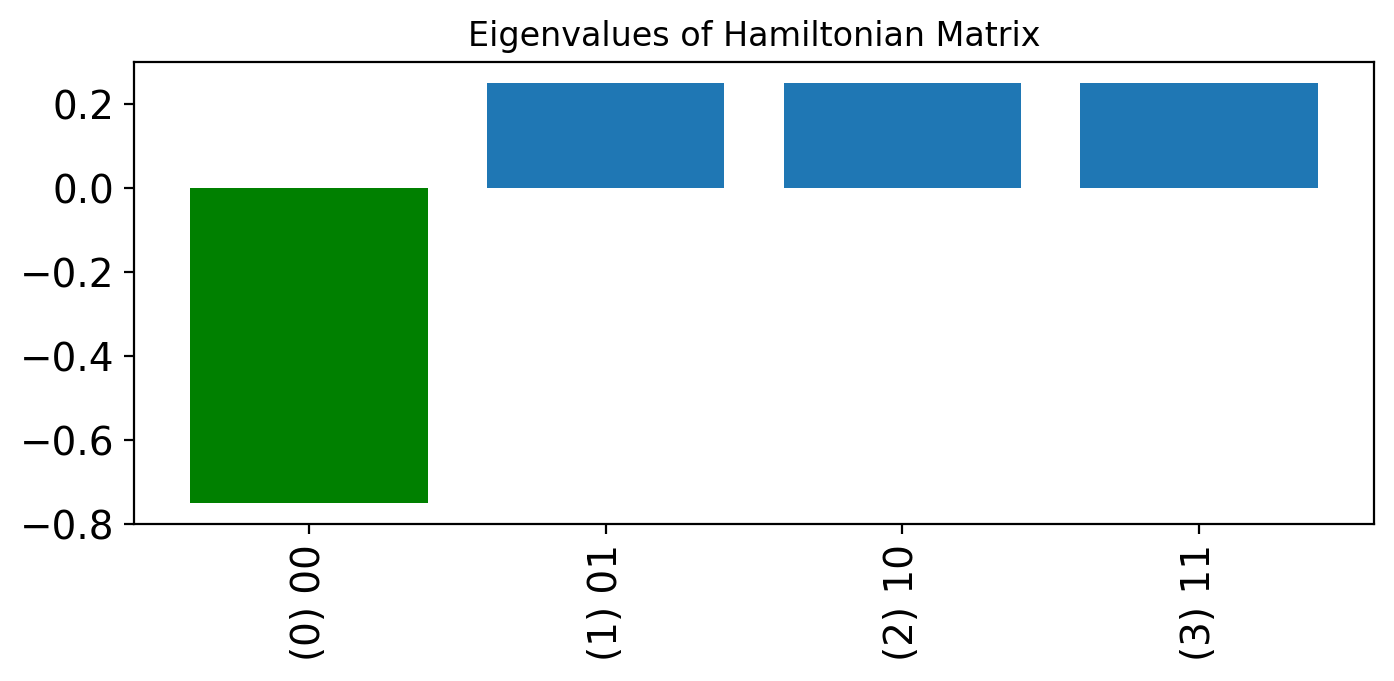

In [76]:
# plot diagonal of matrix
import matplotlib.pyplot as plt
opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]
plt.figure(figsize=(8, 3))
plt.bar(range(2**n), H_matrix.diagonal())
plt.bar(opt_indices, H_matrix.diagonal()[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:02b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.title("Eigenvalues of Hamiltonian Matrix")
plt.show()

This is only 4x4 matrix, which is easy to solve explicitly. However, for more complex matrices it gets harder to solve explicitly. Thus, we will employ Quantum method, called VQE

## 3. Create a parameterized Ansatz:

Define an ansatz, which is a parameterized quantum circuit representing a trial state. The ansatz should have enough flexibility to explore the solution space. 
1. Let's create an ansatz by applying rx rotaions on both qubits. 
2. Or we can define an ansatz from available ansatz in Qiskit

### 3.1 

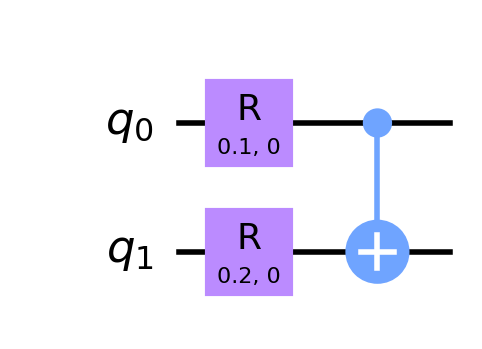

In [32]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

def parameterized_ansatz(params):
    # Create a quantum circuit with 2 qubits
    circuit = QuantumCircuit(H_c.num_qubits)
    
    # Apply parameterized rotations on both qubits
    for i in range(H_c.num_qubits):
        circuit.rx(params[i], i)
    
    # Apply a CNOT gate for entanglement
    for j in range(0, H_c.num_qubits, 2):
        circuit.cx(j,j+1)
    
    return circuit

# Example of using the ansatz with some parameter values
params_example = [0.1, 0.2]
ansatz1 = parameterized_ansatz(params_example)

# Print the circuit
ansatz1.decompose().draw("mpl")

### 3.2

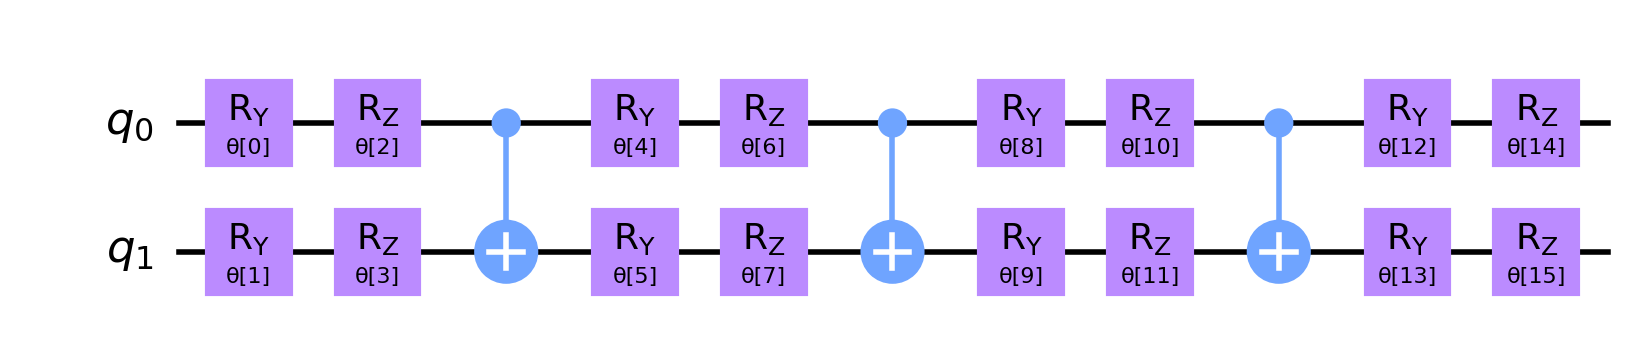

In [33]:
# or can be choosen from Qiskit, ansatz2
from qiskit.circuit.library import EfficientSU2
ansatz2 = EfficientSU2(H_c.num_qubits)
ansatz2.decompose().draw("mpl")

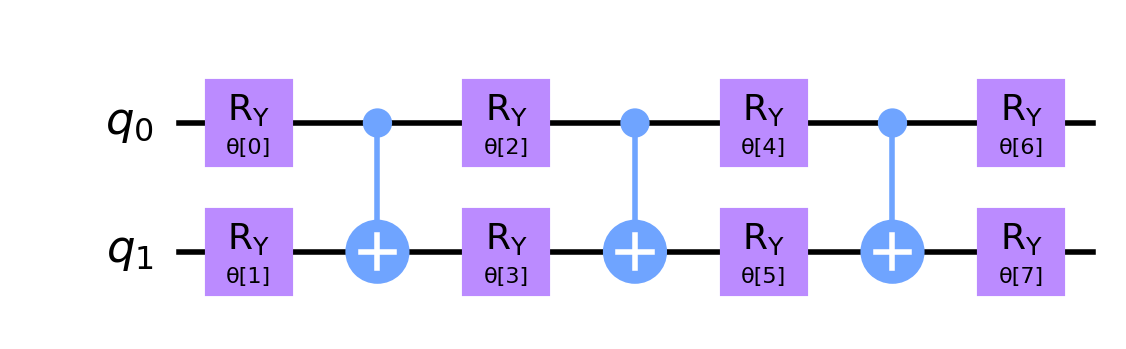

In [34]:
# or can be choosen from Qiskit, ansatz3
from qiskit.circuit.library import RealAmplitudes
ansatz3 = RealAmplitudes(H_c.num_qubits)
ansatz3.decompose().draw("mpl")

## 5. Implement VQE Algorithm:
Apply the VQE algorithm:

* Prepare the initial state using the ansatz.
* Measure the expectation value of the Hamiltonian.
* Use classical optimization to adjust the parameters of the ansatz to minimize the expectation value.

In [35]:
import numpy as np
num_params = ansatz2.num_parameters
num_params
x0 = 2 * np.pi * np.random.random(num_params)

In [36]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian H_c
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

In [44]:
from qiskit.primitives import Estimator
# SciPy minimizer routine
from scipy.optimize import minimize
estimator = Estimator()

result = minimize(cost_func, x0, args=(ansatz2, H_c, estimator), method='cobyla')

## 7. Readout and Interpret Results:
Extract the optimized parameters from the quantum circuit. The final state provides an approximate solution to the optimization problem.

In [39]:
print(result.fun) #get the ground state
print(result.x) # get the ansatz parameters


-0.7499999891780778
[ 6.21449331  5.00845336  2.56790427  4.06658685  3.03912675  2.31606323
  4.36182768  4.95469307  2.82813571  0.83499117  6.00056413  0.36268966
  6.57702318  4.60892235  2.90180157 -0.20321238]


In [40]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.7499999891780778
       x: [ 6.214e+00  5.008e+00 ...  2.902e+00 -2.032e-01]
    nfev: 602
   maxcv: 0.0

# 2. Get intermediate points by applying callback

recommendation: https://qiskit.org/ecosystem/ibm-runtime/locale/es_UN/tutorials/vqe_with_estimator.html

In [54]:
import time
import numpy as np


def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        callback_dict["cost_history"].append(
            estimator.run(ansatz, hamiltonian, parameter_values=current_vector).result().values[0]
        )
        # Grab the current time
        current_time = time.perf_counter()
        # Find the total time of the execute (after the 1st iteration)
        if callback_dict["iters"] > 1:
            callback_dict["_total_time"] += current_time - callback_dict["_prev_time"]
        # Set the previous time to the current time
        callback_dict["_prev_time"] = current_time
        # Compute the average time per iteration and round it
        time_str = (
            round(callback_dict["_total_time"] / (callback_dict["iters"] - 1), 2)
            if callback_dict["_total_time"]
            else "-"
        )
        # Print to screen on single line
        print(
            "Iters. done: {} [Avg. time per iter: {}]".format(callback_dict["iters"], time_str),
            end="\r",
            flush=True,
        )

    return callback

In [55]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "_total_time": 0,
    "_prev_time": None,
}

In [56]:
callback = build_callback(ansatz2, hamiltonian, estimator, callback_dict)
result = minimize(
    cost_func,
    x0,
    args=(ansatz2, hamiltonian, estimator),
    method="cobyla",
    callback=callback,
)

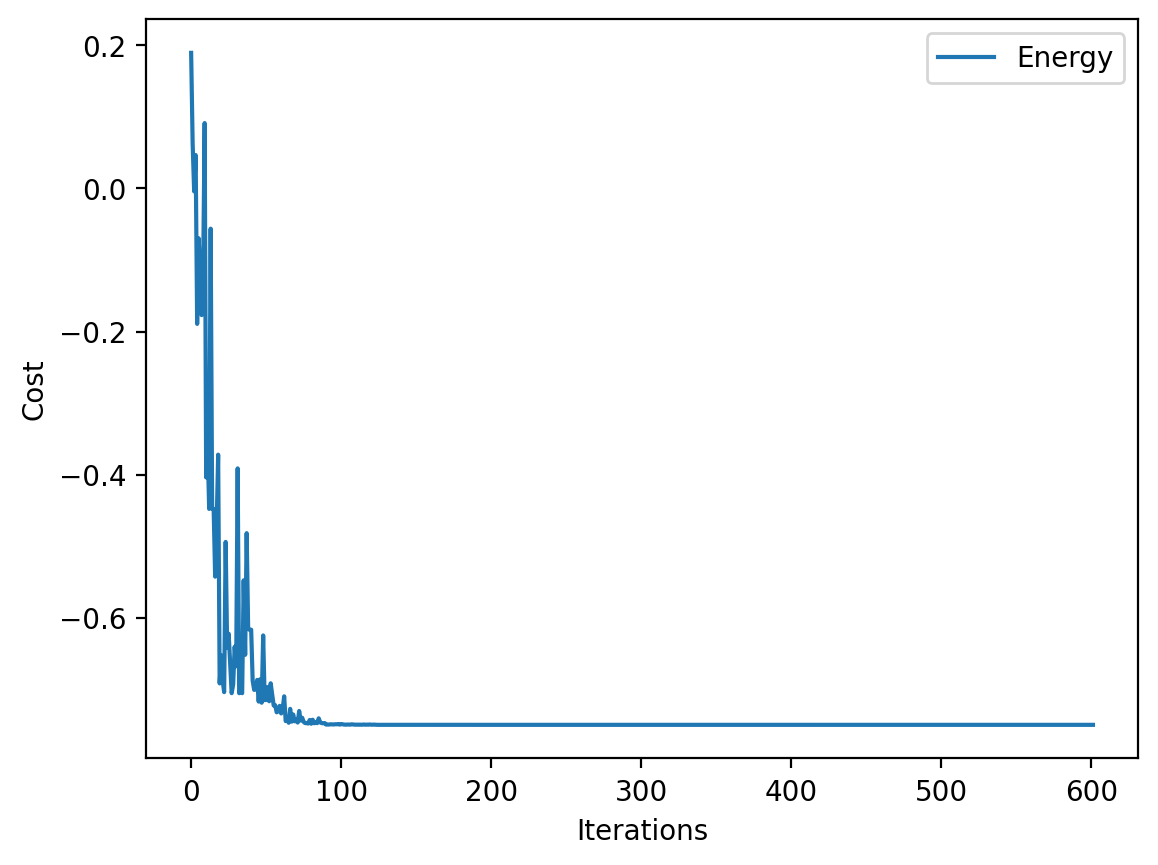

In [57]:
# Plotting functions

fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"], label="Energy")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
ax.legend()

In [58]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.7499999891780778
       x: [ 6.214e+00  5.008e+00 ...  2.902e+00 -2.032e-01]
    nfev: 602
   maxcv: 0.0

# 3. VQE from Qiskit

Qiskit provides VQE function which can be used to solve the same problem

In [65]:
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

counts = []
values = []
parameter =[]
def store_intermediate_result(eval_count, parameters, mean, metadata):
    counts.append(eval_count)
    values.append(mean)
    parameter.append(parameters)

optimizer = COBYLA()

vqe = SamplingVQE(sampler=Sampler(), 
                       ansatz=ansatz2, 
                       optimizer=optimizer, 
                       #initial_point=np.random.random(ansatz3.parameters),
                       callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(H_c)

In [66]:
print(result)

SamplingMinimumEigensolverResult:
	Eigenvalue: -0.7499999955566363
	Best measurement
: {'state': 0, 'bitstring': '00', 'value': (-0.75+0j), 'probability': 0.9999999961786749}



In [67]:
result.eigenstate.binary_probabilities()

{'00': 0.9999999955566365,
 '01': 6.483386e-10,
 '10': 1.0354072e-09,
 '11': 2.7596181e-09}